# Evaluation Notebook

## Load Packages and Metadata

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import os
import gc
import pickle

from typing import Union, Literal, Dict, Optional, Tuple

from eval import (
    read_run_dir,
    get_err_from_run,
    compute_scaling_err,
    get_timed_err_from_run
)
from plot_utils import plot_model_errs

%matplotlib inline
%load_ext autoreload
%autoreload 2


sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

defaulting on: mlp
defaulting on: mlp
defaulting on: mlp
defaulting on: mlp
defaulting on: mlp
defaulting on: mlp
defaulting on: mlp
defaulting on: mlp


,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_standard
1,dcb3f707-0634-451a-bf77-4a7a2d7410e6,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp
2,52036ab7-fa15-4fce-8560-37357fbd2364,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp
3,d1d1a928-43bb-4aac-b4cd-61a522c0698b,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp
4,aca8758b-457c-4684-a9ec-460430ea6250,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp
5,d38ec781-30a3-41a0-99c6-0aab1237fab4,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp
6,0e06abbd-d63a-410a-8a53-c3cdebfedd49,linear_regression,linear_regression_mlp,,-1,-1,20,12,8,linear_regression_mlp
7,97dcd388-0611-4e50-a9d3-445d84c1c43f,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp
8,c57f36ac-86f6-4c65-843c-96ce995e0045,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp


In [31]:
def get_trained_models(task: Union[
        Literal["linear_regression"], 
        Literal["sparse_linear_regression"], 
        Literal["decision_tree"], 
        Literal["relu_2nn_regression"]
    ] = "linear_regression"):
    
    models = df[df.task == task].reset_index(drop=True)
    models["run_path"] = models.apply(lambda row: os.path.join(run_dir, row['task'], row['run_id']), axis=1)
    return models

models = get_trained_models("linear_regression")
models

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name,run_path
0,dcb3f707-0634-451a-bf77-4a7a2d7410e6,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp,../models/linear_regression/dcb3f707-0634-451a...
1,52036ab7-fa15-4fce-8560-37357fbd2364,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp,../models/linear_regression/52036ab7-fa15-4fce...
2,d1d1a928-43bb-4aac-b4cd-61a522c0698b,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp,../models/linear_regression/d1d1a928-43bb-4aac...
3,aca8758b-457c-4684-a9ec-460430ea6250,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp,../models/linear_regression/aca8758b-457c-4684...
4,d38ec781-30a3-41a0-99c6-0aab1237fab4,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp,../models/linear_regression/d38ec781-30a3-41a0...
5,0e06abbd-d63a-410a-8a53-c3cdebfedd49,linear_regression,linear_regression_mlp,,-1,-1,20,12,8,linear_regression_mlp,../models/linear_regression/0e06abbd-d63a-410a...
6,97dcd388-0611-4e50-a9d3-445d84c1c43f,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp,../models/linear_regression/97dcd388-0611-4e50...
7,c57f36ac-86f6-4c65-843c-96ce995e0045,linear_regression,linear_regression_mlp,,-1,-1,20,3,2,linear_regression_mlp,../models/linear_regression/c57f36ac-86f6-4c65...


## Plot Generation

We will now directly load the model and measure its in-context learning ability on a larger batch of random inputs. (We expand the batch size to obtain better estimates)

### Function and Baseline definitions

In [32]:
bs_x = lambda factor: (lambda bs: bs * factor)
bs = lambda batch_size: (lambda _: batch_size)
scale = lambda factor: (lambda x: x * factor)

optimals = {
    "linear_regression" : {
        "error": torch.concat((torch.arange(20, -1, -1), torch.zeros((21, )))),
        "label" : "Least Squares"
    }
}

naives = {
    "linear_regression" : 20,
    "sparse_linear_regression" : 3,
    "decision_tree" : 1
}

def get_label(run_id):
    return {
        "pretrained" : "Transformer",
        "pretrained_relu" : "Transformer-ReLU",
        "pretrained_quantized" : "Transformer-Int8",
        "pretrained_relu_quantized" : "ReLU + Int8",
        "pretrained_relu_causal" : "Relu-Causal",
        "pretrained_relu_causal_quantized" : "Relu-Causal + Int8",
        "defaulting on: mlp" : "MLP"
    }.get(run_id, "Unknown")

def plot_model_errs(errors: Dict[str, torch.Tensor], baseline: int, optimal: Optional[Tuple[str, torch.Tensor]] = None, no_std_dev: bool = False):
    for run_id, err in errors.items():
        loss_means = err.mean(axis=0)
        label_suffix = "" if no_std_dev else "($\mu \; \pm \; 1\sigma$)"

        plt.plot(loss_means, lw=2, label=f"{get_label(run_id)} {label_suffix}")

        if not no_std_dev:
            loss_stds  = err.std(axis=0)
            plt.fill_between(list(range(loss_means.shape[0])), loss_means-loss_stds, loss_means+loss_stds, alpha=0.2, linewidth=0, antialiased=True)
    
    if optimal is not None:
        plt.plot(optimal[1], label=optimal[0])
    
    plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
    plt.xlabel("# in-context examples")
    plt.ylabel("squared error")
    plt.legend()

def compute_errs(task, context_length, mutate_xs=(lambda x: x), cache=False, cache_file_suffix=None):
    suff = "" if cache_file_suffix is None else f"_{cache_file_suffix}"
    cache_file = f"eval/{task}_errs{suff}.pkl"
    models = get_trained_models(task)
    errs = {}

    if cache and os.path.isfile(cache_file):
        with open(cache_file, "rb") as f:
            errs = pickle.load(f)
    
    for _, row in models.iterrows():
        if cache and row["run_id"] in errs:
            continue

        errs[row["run_id"]] = get_err_from_run(
            row["run_path"],
            mutate_xs=mutate_xs,
            mutate_bs=bs(BATCH_SIZE),
            runs=RUNS,
            ic_examples=context_length
        ).cpu()
        
        gc.collect()
        torch.cuda.empty_cache()

    if cache:
        with open(cache_file, "wb") as f:
            pickle.dump(errs, f)
    
    return errs

if not os.path.isdir("eval/"):
    os.mkdir("eval/")

### Error across all models

In [33]:
BATCH_SIZE = 1024
RUNS = 500

def get_errs(task, context):
    return compute_errs(
        task, context,
        cache=True,
    )

#### Linear Regression

In [34]:
task = "linear_regression"
errs = get_errs(task, 41)

In [27]:
_ = errs.pop("pretrained_relu_quantized")

KeyError: 'pretrained_relu_quantized'

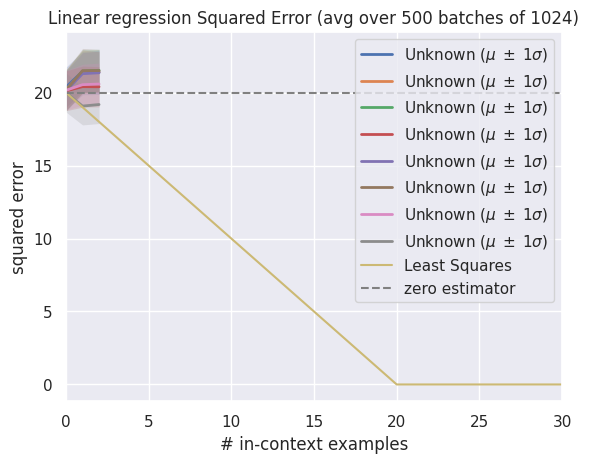

In [35]:
plt.title(f"{task.replace('_', ' ').capitalize()} Squared Error (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"])
    
plot_model_errs(errs, baseline=naives[task], optimal=oracle)
plt.xlim(0, 30)
plt.show()

#### Decision Trees

In [ ]:
task = "decision_tree"
errs = get_errs(task, 101)

In [ ]:
_ = errs.pop("pretrained_relu_quantized")

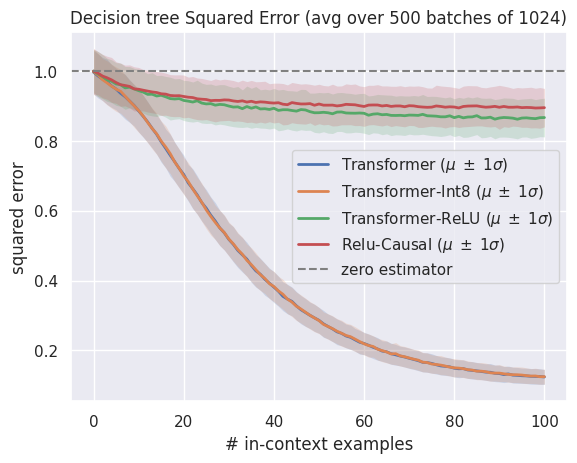

In [ ]:
plt.title(f"{task.replace('_', ' ').capitalize()} Squared Error (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"])

plot_model_errs(errs, baseline=naives[task], optimal=oracle)

#### Sparse Linear Regression

In [ ]:
task = "sparse_linear_regression"
errs = get_errs(task, 41)

In [ ]:
_ = errs.pop("pretrained_relu_quantized")

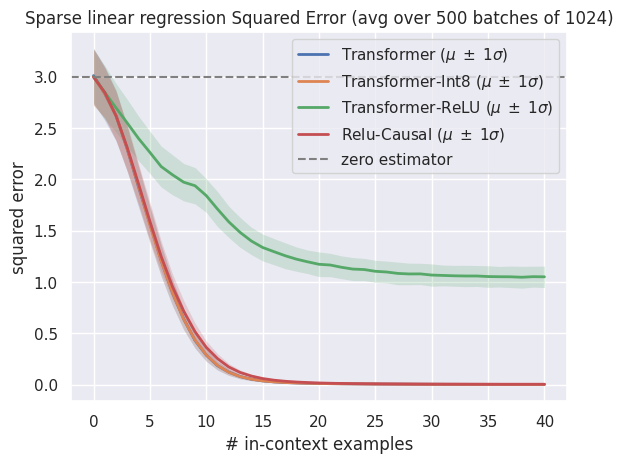

In [ ]:
plt.title(f"{task.replace('_', ' ').capitalize()} Squared Error (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"])

plot_model_errs(errs, baseline=naives[task], optimal=oracle)

### Doubled Inputs

In [ ]:
BATCH_SIZE = 1024
RUNS = 500
double = scale(2)

def get_errs(task, context):
    return compute_errs(
        task, context, 
        mutate_xs=double, 
        cache=True,
        cache_file_suffix="dbl"
    )

#### Linear Regression

In [ ]:
task = "linear_regression"
errs = get_errs(task, 41)

In [ ]:
_ = errs.pop("pretrained_relu_quantized")

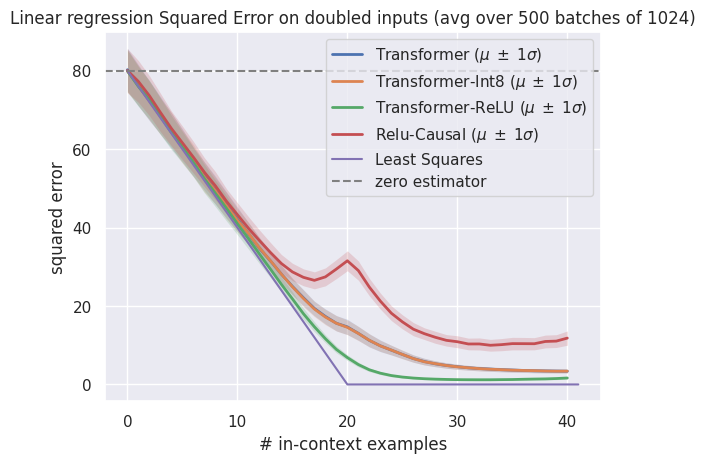

In [ ]:
plt.title(f"{task.replace('_', ' ').capitalize()} Squared Error on doubled inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * double(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= double(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
    # no_std_dev=True
)

#### Decision Trees

In [ ]:
task = "decision_tree"
errs = get_errs(task, 101)

In [ ]:
_ = errs.pop("pretrained_relu_quantized")

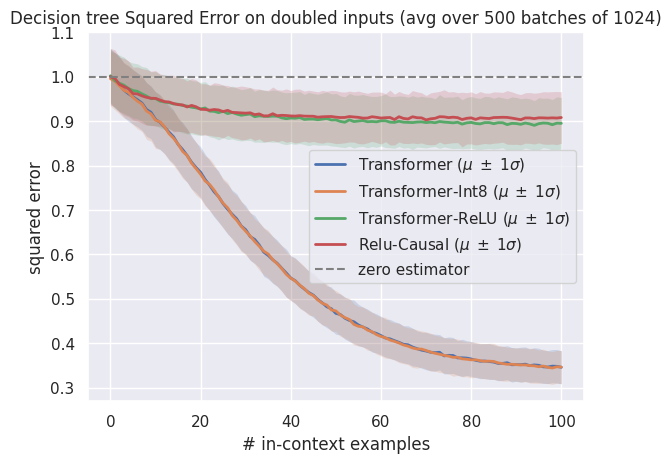

In [ ]:
plt.title(f"{task.replace('_', ' ').capitalize()} Squared Error on doubled inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * double(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= double(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
    # no_std_dev=True
)

#### Sparse Linear Regression

In [ ]:
task = "sparse_linear_regression"
errs = get_errs(task, 41)

In [ ]:
_ = errs.pop("pretrained_relu_quantized")

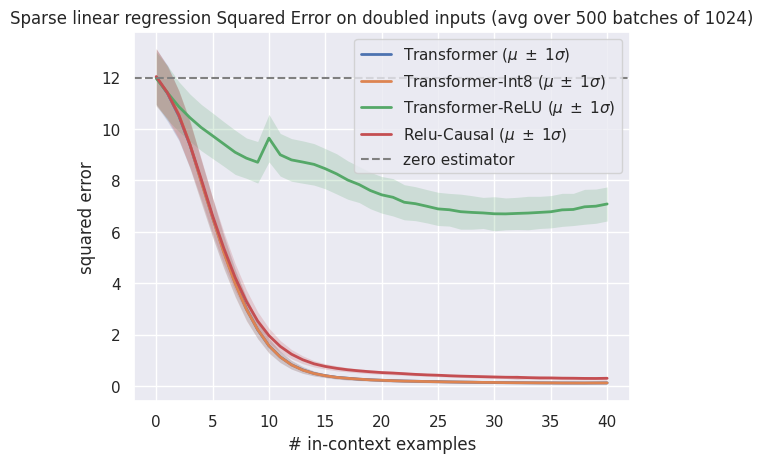

In [ ]:
plt.title(f"{task.replace('_', ' ').capitalize()} Squared Error on doubled inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * double(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= double(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
)

### Halving Inputs

In [ ]:
BATCH_SIZE = 1024
RUNS = 500
halve = scale(0.5)

def get_errs(task, context):
    return compute_errs(
        task, context,
        mutate_xs=halve,
        cache=True,
        cache_file_suffix="hlf"
    )

#### Linear Regression

In [ ]:
task = "linear_regression"
errs = get_errs(task, 41)

In [ ]:
_ = errs.pop("pretrained_relu_quantized")

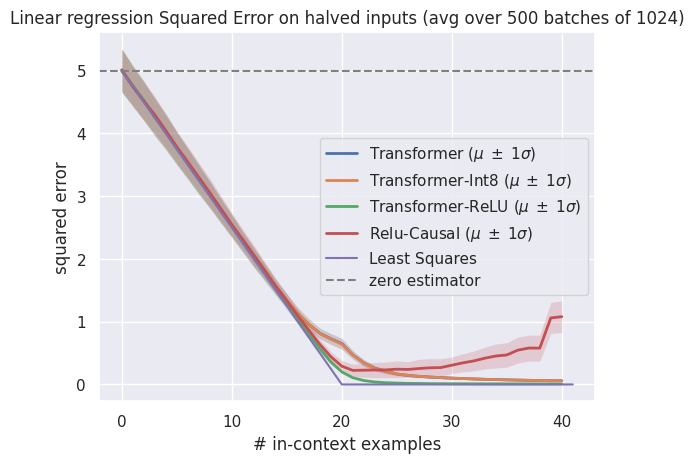

In [ ]:
plt.title(f"{task.replace('_', ' ').capitalize()} Squared Error on halved inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * halve(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= halve(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
    # no_std_dev=True
)

#### Decision Trees

In [ ]:
task = "decision_tree"
errs = get_errs(task, 101)

In [ ]:
_ = errs.pop("pretrained_relu_quantized")

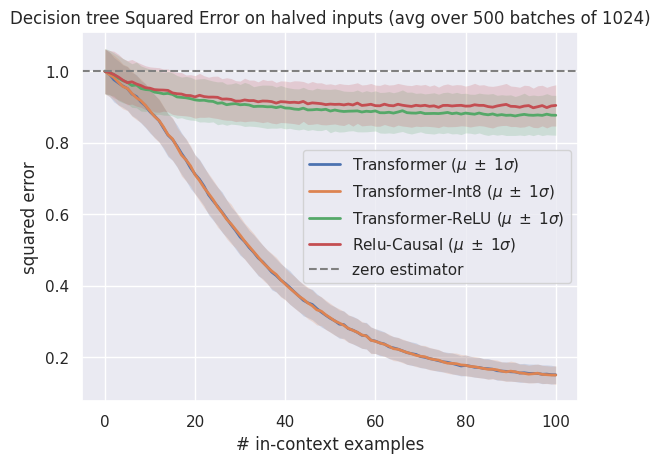

In [ ]:
plt.title(f"{task.replace('_', ' ').capitalize()} Squared Error on halved inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * halve(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= halve(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
    # no_std_dev=True
)

#### Sparse Linear Regression

In [ ]:
task = "sparse_linear_regression"
errs = get_errs(task, 41)

In [ ]:
_ = errs.pop("pretrained_relu_quantized")

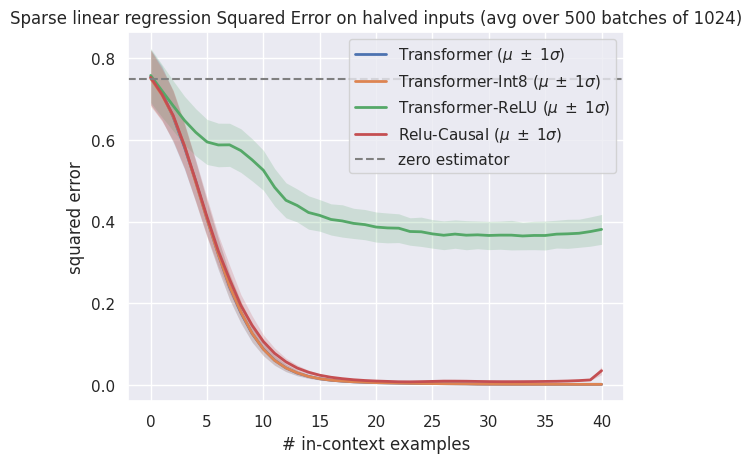

In [ ]:
plt.title(f"{task.replace('_', ' ').capitalize()} Squared Error on halved inputs (avg over {RUNS} batches of {BATCH_SIZE})")

oracle = None
if task in optimals.keys():
    oracle = (optimals[task]["label"], optimals[task]["error"] * halve(1)**2)

baseline = naives[task]
if task in ("linear_regression", "sparse_linear_regression"):
    baseline *= halve(1)**2
    
plot_model_errs(
    errs,
    baseline=baseline,
    optimal=oracle
    # no_std_dev=True
)

### Varying scaling factor

In [ ]:
def get_scaling_errs(scales, models, bsize=256, runs=1, ic_examples=None, cache=False):
    task = models.iloc[0]['task']
    cache_file = f"eval/{task}_scaling_errs.pkl"
    errs = {}

    if cache and os.path.isfile(cache_file):
        print(f"Using cache file {cache_file}")
        with open(cache_file, "rb") as f:
            errs = pickle.load(f)
    
    for _, row in models.iterrows():
        label = get_label(row['run_id'])
        if cache and row['run_id'] in errs:
            print(f"Loading cached error for {label}")
            continue
        
        print(f"Computing error for {label}")
        err = compute_scaling_err(
            row['run_path'],
            mutate_bs=bs(bsize),
            scales=scales,
            runs=runs,
            ic_examples=ic_examples
        ).mean(axis=1)
        
        errs[row['run_id']] = err

        gc.collect()
        torch.cuda.empty_cache()

    if cache:
        with open(cache_file, "wb") as f:
            pickle.dump(errs, f)
    
    return errs

In [ ]:
def plot_scaling_errs(errs, ic_example_counts, normalize_errs=True, max_y=50, task="linear_regression"):
    fig, ax = plt.subplots(1, len(ic_example_counts), sharey='all')
    fig.set_size_inches(20, 5)
    for i, ic_examples in enumerate(ic_example_counts):
        for run_id, err in errs.items():
            ys = err[:, ic_examples].cpu() / (scales ** 2) if normalize_errs else err[:, ic_examples]
            ax[i].plot(scales, ys, label=get_label(run_id))

        ax[i].set_title(f"Error with {ic_examples} examples")
        ax[i].set_xscale('log')
        ax[i].set_xlabel("Scaling factor")
        ax[i].set_ylim(0, max_y)

        naive = naives[task]
        if task in optimals.keys():
            optim = torch.concat((optimals[task]["error"], torch.zeros((max(ic_example_counts)-19, ))))[ic_examples]
        if normalize_errs: 
            ax[i].axhline(naive, ls="--", color="gray", label="zero estimator")
            if task in optimals.keys():
                ax[i].axhline(optim, ls="--", color="blue", label=optimals[task]["label"])
        else:
            ax[i].set_yscale('log')

            naive *= scales ** 2
            ax[i].plot(naive, ls="--", color="gray", label="zero estimator")
            
            if task in optimals.keys():
                optim *= scales ** 2
                ax[i].plot(optim, ls="--", color="blue", label=optimals[task]["label"])

        if i == 0:
            ax[i].set_ylabel("squared error")

        if i == 0:
            ax[i].legend()

    return fig

#### Linear Regression

In [ ]:
scales = np.concatenate((np.arange(0.1, 1, 0.1), np.arange(1, 11.)))
models = get_trained_models("linear_regression")
scaling_errs = get_scaling_errs(
    scales, models, 
    bsize=1024,
    runs=10,
    ic_examples=41,
    cache=True
)

Using cache file eval/linear_regression_scaling_errs.pkl
Loading cached error for Transformer
Loading cached error for Transformer-ReLU
Loading cached error for Relu-Causal


In [ ]:
_ = scaling_errs.pop("pretrained_relu_quantized")

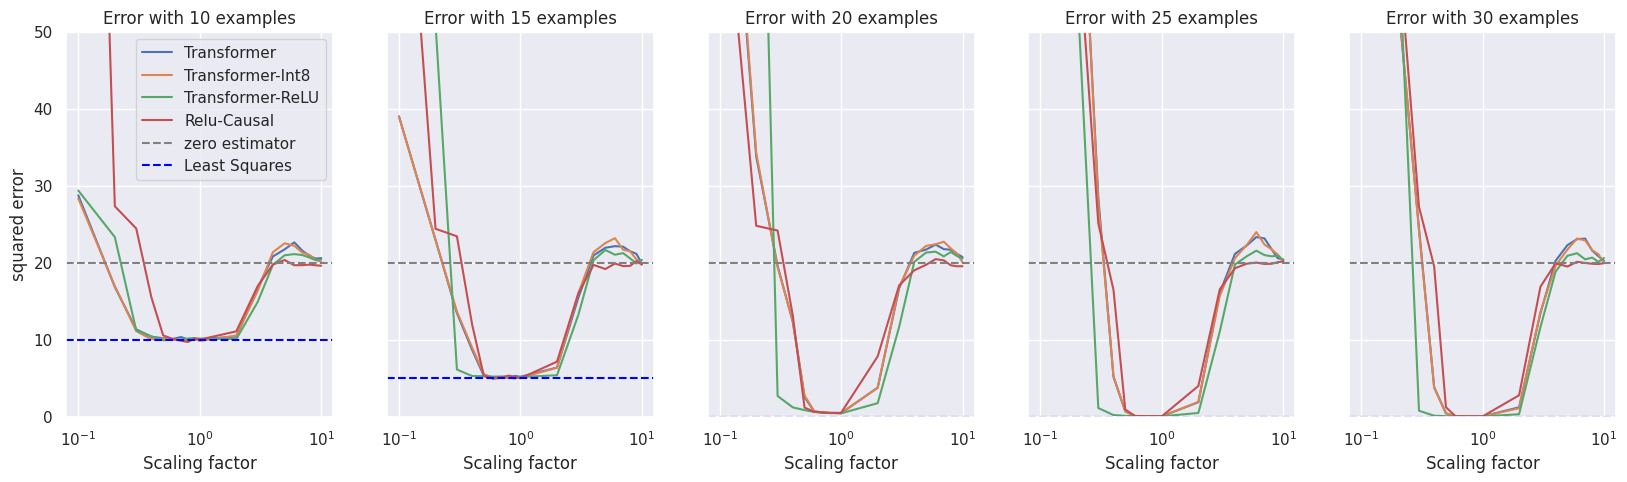

In [ ]:
f = plot_scaling_errs(scaling_errs, [10, 15, 20, 25, 30], max_y=50)
f.show()

#### Decision Trees

In [ ]:
scales = np.concatenate((np.arange(0.1, 1, 0.1), np.arange(1, 11.)))
models = get_trained_models("decision_tree")
scaling_errs = get_scaling_errs(
    scales, models, 
    bsize=1024,
    runs=10,
    ic_examples=100,
    cache=True
)

Using cache file eval/decision_tree_scaling_errs.pkl
Loading cached error for Transformer
Loading cached error for Transformer-ReLU
Loading cached error for Relu-Causal


In [ ]:
_ = scaling_errs.pop("pretrained_relu_quantized")

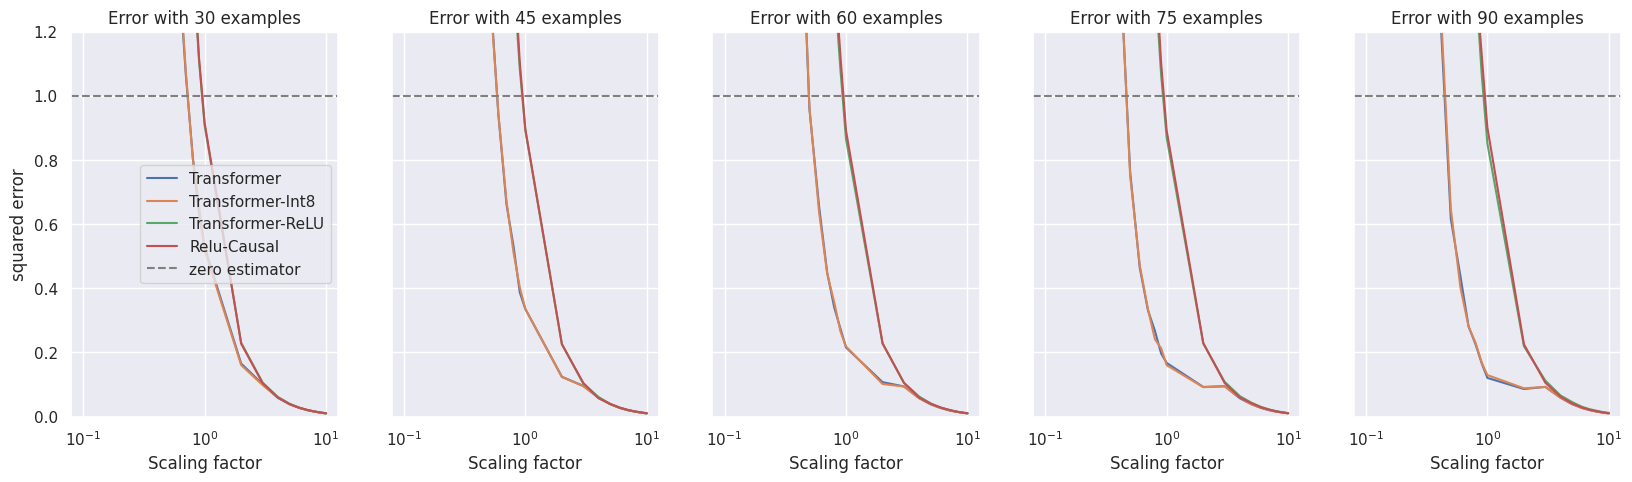

In [ ]:
f = plot_scaling_errs(scaling_errs, [30, 45, 60, 75, 90], max_y=1.2, task="decision_tree")
f.show()

#### Sparse Linear Regression

In [ ]:
scales = np.concatenate((np.arange(0.1, 1, 0.1), np.arange(1, 11.)))
models = get_trained_models("sparse_linear_regression")
scaling_errs = get_scaling_errs(
    scales, models, 
    bsize=1024,
    runs=10,
    ic_examples=41,
    cache=True
)

Using cache file eval/sparse_linear_regression_scaling_errs.pkl
Loading cached error for Transformer
Loading cached error for Transformer-ReLU
Loading cached error for Relu-Causal


In [ ]:
_ = scaling_errs.pop("pretrained_relu_quantized")

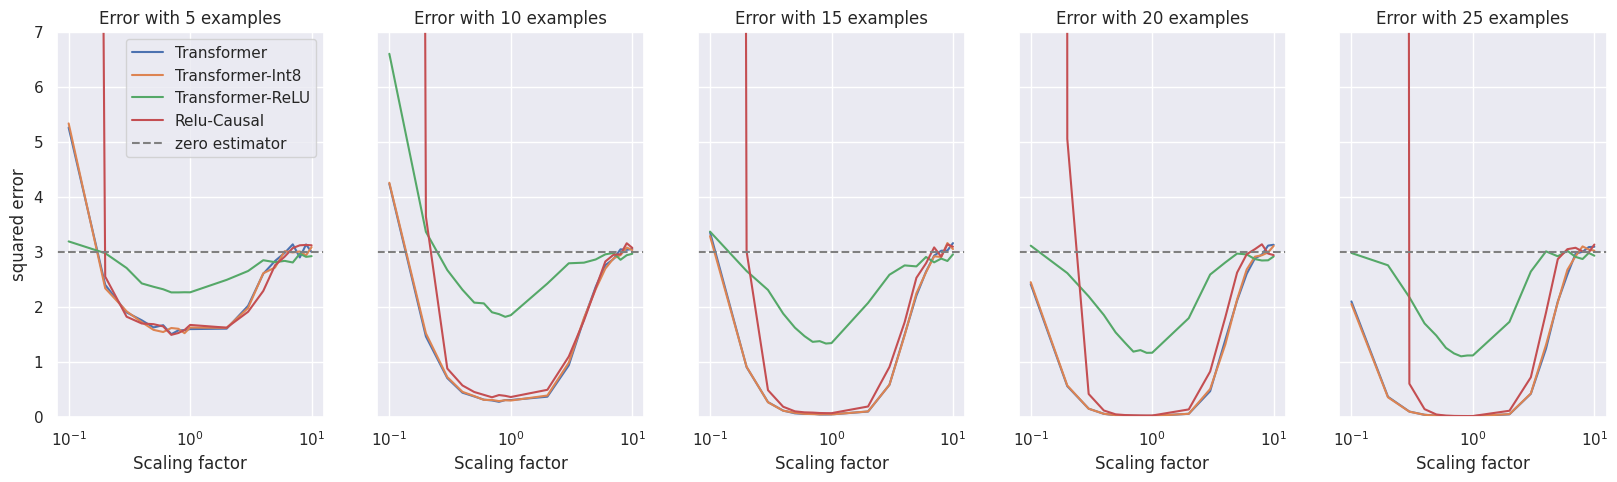

In [ ]:
# Sparse Linear Reg
plot_scaling_errs(scaling_errs, [5, 10, 15, 20, 25], max_y=7, task="sparse_linear_regression").show()

### Inference time

In [ ]:
models = get_trained_models("linear_regression")
BATCHES = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
RUNS = 50

run_data = {
    row["run_id"] : {
        "path" : row["run_path"],
        "errs" : [], "times" : []
    } for _, row in models.iterrows()
}

for batch in BATCHES:
    print(f"Running batches of size {batch} ... ", end='')
    for model_type in run_data.keys():
        err, times = get_timed_err_from_run(run_data[model_type]["path"], mutate_bs=(lambda bs: batch), runs=RUNS)
        
        run_data[model_type]['errs'].append(err.cpu())
        run_data[model_type]['times'].append(times)

for model_type in run_data.keys():
    run_data[model_type]['errs'] = torch.stack(run_data[model_type]['errs']).cpu()
    run_data[model_type]['times'] = torch.tensor(run_data[model_type]['times'])

with open('eval/varying_batch_times.pkl', 'wb') as f:
    pickle.dump((run_data, BATCHES, RUNS), f)

Running batches of size 32 ... 

Timing runs: 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Running batches of size 64 ... 

Timing runs: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Running batches of size 128 ... 

Timing runs: 100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


Running batches of size 256 ... 

Timing runs: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Running batches of size 512 ... 

Timing runs: 100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


In [ ]:
def filter_outliers(inp):
    ts = np.array(inp)
    iqr = np.quantile(ts, .75) - np.quantile(ts, .25)
    upper_bound = iqr * 1.5 + np.quantile(ts, .75)
    valid = ts <= upper_bound
    return ts[valid]

In [ ]:
with open('eval/varying_batch_times.pkl', 'rb') as f:
    run_data, BATCHES, RUNS = pickle.load(f)

# Sanity check
ts = np.array(run_data["pretrained"]['times'])
assert ts.shape == (len(BATCHES), RUNS), f"exp: {(len(BATCHES), RUNS)}, got: {ts.shape}"

IC_EXAMPLES = [20]
colors=["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan",  "black", "red"]
markers = ["o", "^", "." , "s" , "P" , "v" , "1", "3", "*", "x", "d", "X", "8"]

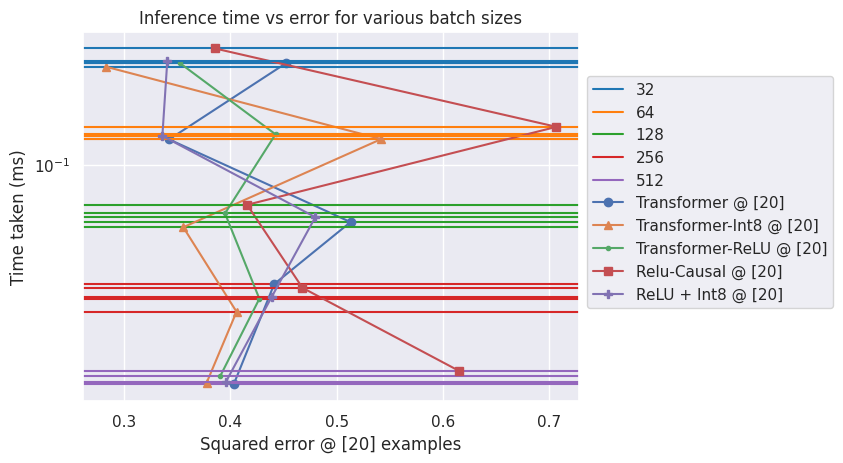

In [ ]:
labels_made = False
for marker, model_type in zip(markers, run_data.keys()):
    errs = run_data[model_type]["errs"][:, IC_EXAMPLES]

    mean_times = [
        filter_outliers(raw_batch_times).mean() * 1e3
        for raw_batch_times in run_data[model_type]["times"]
    ]
    
    for avg_batch_time, batch_size, color in zip(mean_times, BATCHES, colors):
        if not labels_made:
            plt.axhline(avg_batch_time, color=color, label=batch_size)
        else:
            plt.axhline(avg_batch_time, color=color) # [c for c, ic, errs in zip(colors, IC_EXAMPLES, errs.T)]
    labels_made = True

    plt.plot(errs.cpu().numpy(), mean_times, marker=marker, label=f"{get_label(model_type)} @ {IC_EXAMPLES}")


plt.yscale('log')
plt.title(f"Inference time vs error for various batch sizes")
plt.ylabel("Time taken (ms)")
plt.xlabel(f"Squared error @ {IC_EXAMPLES} examples")
plt.legend(bbox_to_anchor=(1., 0.9))

In [ ]:
RUNS = 1000
TIMING_BATCH_SIZE = 2048

fixed_batch_size = lambda bs: TIMING_BATCH_SIZE

d = {}
for _, row in models.iterrows():
    err, time = get_timed_err_from_run(row["run_path"], mutate_bs=bs(TIMING_BATCH_SIZE), runs=RUNS)
    d[row["run_id"]] = {
        "errs" : err,
        "times": time
    }

with open("eval/losses_and_times.pkl", 'wb') as f:
    pickle.dump(d, f)

In [ ]:
sns.histplot({
    get_label(run_id) : vals
    for run_id, vals in out.items()
})
plt.xlabel("Time (s)")

In [ ]:
def format_times(times, title):
    print(title, f"(count: {times.shape}, mean: {np.mean(times)*1e3} +- {np.std(times)*1e3})")

In [ ]:
with open("eval/losses_and_times.pkl", "rb") as f:
    raw_times = pickle.load(f)

out = {}
for run_id, vals in raw_times.items():
    times = filter_outliers(vals["times"])
    out[run_id] = times

    format_times(times, f"{get_label(runid)} Times :")